In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

#Prepare the data.
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from numpy import linalg as LA

dtype = torch.FloatTensor

images = np.load("./data/images.npy")
labels = np.load("./data/labels.npy")

images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))
#images = images - images.mean()
#images = images/images.std()
#i1 = images[0]
#print(i1.std())

train_seqs = images[0:40000]
val_seqs = images[40000:50000]

train_labels = labels[0:40000]
cv_labels = labels[40000:50000]

In [13]:
def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

import random
def approx_train_accuracy():
    model.eval()
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    model.eval()
    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int) 
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)

    return acc


In [119]:
from skimage import util
from skimage import transform
import random
HEIGHT, WIDTH = 26, 26
def display(image):
    plt.figure()
    plt.imshow(image)
    plt.set_cmap('gray')
#Transfrorm function to perform random crops and flip
def random_tansform(im):
    #image = Variable(torch.from_numpy(im.astype(np.float32)))
    #im = image.view(-1, HEIGHT, WIDTH).unsqueeze(1)
    im2 = im.reshape((26,26))
    size = random.randint(10,30)
    #im2 = util.crop(im2, 2)
    #print(im2.shape)
    #display(im2)
    im2 = transform.rotate(im2, 90)
    #print(im2.shape)
    #display(im2)
    #im2 = transform.resize(im2, (im2.shape[0]+4, im2.shape[0]+4))
    #print(im2.shape)
    #display(im2)
    return im2.reshape((1,676))
#i = train_seqs[0]
#random_tansform(i)

In [120]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class MaxPerformanceCNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.batchNorm1 = torch.nn.BatchNorm2d(16)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.batchNorm2 = torch.nn.BatchNorm2d(32)
        
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.batchNorm3 = torch.nn.BatchNorm2d(64)
        
        self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.batchNorm4 = torch.nn.BatchNorm2d(128)
        
        self.final_conv = torch.nn.Conv2d(128,5, kernel_size=1)
        """
        
        self.conv1 = torch.nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.batchNorm1 = torch.nn.BatchNorm2d(20)
        
        self.conv2 = torch.nn.Conv2d(20, 40, kernel_size=3, stride=1)
        self.batchNorm2 = torch.nn.BatchNorm2d(40)
        
        self.conv3 = torch.nn.Conv2d(40, 80, kernel_size=3, stride=1)
        self.batchNorm3 = torch.nn.BatchNorm2d(80)
        
        self.conv4 = torch.nn.Conv2d(80, 160, kernel_size=3, stride=1)
        self.batchNorm4 = torch.nn.BatchNorm2d(160)
        
        self.final_conv = torch.nn.Conv2d(160,5, kernel_size=1)
        
    
    def forward(self, x):
        
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        #x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        #x = F.dropout(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, kernel_size=2, stride=2)
        #x = F.dropout(x)
        
        """
        x = self.conv3(x)
        x = self.batchNorm3(x)
        n, c, h, w = x.size()
        
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=[h,w])
        x = F.dropout(x)
        """
        x = self.conv3(x)
        x = self.batchNorm3(x)
        #n, c, h, w = x.size()
        x = F.relu(x)
        #x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv4(x)
        x = self.batchNorm4(x)
        #n, c, h, w = x.size()
        x = F.relu(x)
        n, c, h, w = x.size()
        x = F.max_pool2d(x, kernel_size=[h,w])
        x = F.dropout(x)
        
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        
        return x
        

model = MaxPerformanceCNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = train_seqs[i]#.astype(np.float32)
    for it in range(x.shape[0]):
        x[it] = random_tansform(x[it])
    ip = Variable(torch.from_numpy(x.astype(np.float32)))
    #x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    
    optimizer.zero_grad()
    y_hat = model(ip)
    loss = F.cross_entropy(y_hat, y)
    #loss = F.nll_loss(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_accs, val_accs = [], []
batch_size = 200
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.19  0.21
   100  0.20  0.20
   200  0.21  0.19
   300  0.18  0.18
   400  0.20  0.21
   500  0.21  0.21
   600  0.20  0.21
   700  0.22  0.21
   800  0.19  0.19
   900  0.19  0.19


KeyboardInterrupt: 

max_train accuracy:  0.999
max_val accuracy:  0.968


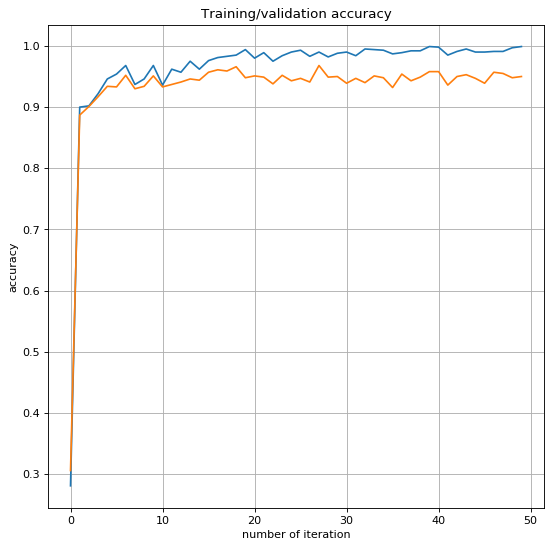

In [39]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

In [40]:
#Testing on kaggle data set.
#Generate a csv file with predictions.

#load the test data.

model.eval()
test_data = np.load("./data/part_2_test_images.npy")
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1]*test_data.shape[2]))

output = np.empty((5000, 2), dtype=np.uint0)
for i in range(test_data.shape[0]):
    x = Variable(torch.from_numpy(test_data[i].astype(np.float32)))
    out = model(x)
    label = np.argmax(out.data.numpy(), axis =1)
    output[i] = [i, label[0]]

np.savetxt('out_exp1_comp.csv', output, delimiter=",",fmt='%1.0f', header="id,label")